In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

2024-11-08 13:18:03.499760: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 13:18:08.033980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731068290.562297 3914695 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731068291.075002 3914695 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 13:18:15.501825: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Def various functions for labels transformation and common sense error

In [2]:
def periodic_trans(time):
    time_period = np.round([np.cos(time[:,0]/12*2*np.pi),
                            np.sin(time[:,0]/12*2*np.pi),
                            np.cos(time[:,1]/60*2*np.pi),
                            np.sin(time[:,1]/60*2*np.pi)],5)
    return time_period.T

def period_to_hrmin(period_time,hr_or_min):
    # convert period to clk time (either hr or min, for hr use 12, for min use 60 for hr_or_min)
    time_y_rad = np.arctan2(period_time[:,1],period_time[:,0])
    time_y = (time_y_rad < 0)*2*np.pi + time_y_rad
    time_clk = time_y/2/np.pi*hr_or_min
    return np.round(time_clk)

def period_to_clk(period_time):
    return np.array([period_to_hrmin(period_time[:,:2],12),
                     period_to_hrmin(period_time[:,2:],60)]).T

# ty1 = period_to_clk(train_ty_period)
# test_ty_period = periodic_trans(test_ty)

def calculate_angle(vec1, vec2):
    dot_product = np.sum(vec1 * vec2, axis=1)
    mag1 = np.linalg.norm(vec1, axis=1)
    mag2 = np.linalg.norm(vec2, axis=1)
    cos_theta = dot_product / (mag1 * mag2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid domain errors
    return angle

def common_sense_err(test_y,pred_y):
    hr_angle = calculate_angle(test_y[:,:2],pred_y[:,:2])
    min_angle = calculate_angle(test_y[:,2:],pred_y[:,2:])
    hr_diff = hr_angle/2/np.pi*12
    min_diff = min_angle/2/np.pi*60
    return np.round(np.array([hr_diff,min_diff]).T)

def single_angle_trans(clk_time):
    time_rad = clk_time[:,0]/12*2*np.pi + clk_time[:,1]/60*np.pi/6
    time_per = np.array(np.round([np.cos(time_rad),
                                  np.sin(time_rad)],5)).T
    return time_per

def s_ang_to_clk(s_angle):
    y_rad = np.arctan2(s_angle[:,1],s_angle[:,0])
    y_rad2 = (y_rad < 0)*2*np.pi + y_rad
    y_clk = y_rad2/2/np.pi*12
    return np.array([y_clk.astype(int),np.round(y_clk%1*60)]).T

def common_sense_err2(test_y,pred_y):
    sa1 = single_angle_trans(pred_y)
    sa2 = single_angle_trans(test_y)
    sa_diff = calculate_angle(sa1,sa2)
    hr_diff = sa_diff//(np.pi/6)
    min_diff = np.round((sa_diff%(np.pi/6)*6*60/np.pi))
    return np.array([hr_diff,min_diff]).T

# train_ty_period = periodic_trans(train_ty)
# print(train_ty_period[:10])
# train_ty_period[:,2:]

# y1 = period_to_hrmin(train_ty_period[:,2:],60)
# tt1 = test_ty_period[:3]
# tt2 = train_ty_period[:3]
# train_ty[:10]
# calculate_angle(tt1[:,:2],tt2[:,:2])
# print(common_sense_err(tt1,tt2))

# tt3 = single_angle_trans(train_ty[:3])
# tt4 = single_angle_trans(test_ty[:3])
# sa1 = calculate_angle(tt3,tt4)

# common_sense_err2(train_ty[:3],test_ty[:3])

### 75 x 75 Data

In [ ]:
time_x = np.load('s_images.npy')
time_y = np.load('s_labels.npy')
train_tx, test_tx, train_ty, test_ty = train_test_split(time_x, time_y, test_size=0.1, random_state=42)
train_ty[:10],test_ty[:10]
train_ty_period = periodic_trans(train_ty)
test_ty_period = periodic_trans(test_ty)
train_ty_period[:,2:]


array([[-0.97815,  0.20791],
       [-0.91355, -0.40674],
       [ 0.97815, -0.20791],
       ...,
       [-0.86603, -0.5    ],
       [-0.91355, -0.40674],
       [-0.99452, -0.10453]])

In [ ]:
train_tx[:,1]
train_ty

array([[11, 28],
       [ 6, 34],
       [ 9, 58],
       ...,
       [ 3, 35],
       [ 0, 34],
       [10, 31]])

Model Type 5.1: Multi-head with scaled regression

In [ ]:
K.clear_session()


input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(1,name='min_y')(min_y)

model_time_MH1 = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH1.summary()
print(model_time_MH1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH1.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH1 = model_time_MH1.fit(train_tx, {'hr_y': train_ty[:,0], 'min_y': train_ty[:,1]/59},
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping, reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 75, 75, 1) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 73, 73,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 877,997 (3.35 MB)

 Trainable params: 877,549 (3.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>


2024-11-08 10:16:17.408620: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 248 bytes spill stores, 272 bytes spill loads



57/57 - 1s - 17ms/step - hr_y_accuracy: 0.9478 - hr_y_loss: 0.1888 - loss: 0.4503 - min_y_loss: 0.0225 - min_y_mae: 0.0947


[0.4503194987773895,
 0.1887856423854828,
 0.022547371685504913,
 0.9477777481079102,
 0.09466080367565155]

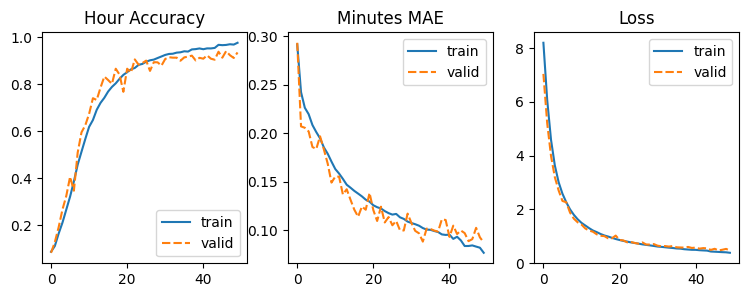

In [ ]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH1.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH1.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH1.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH1.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH1.history['loss']
loss_df['valid'] = his_model_time_MH1.history['val_loss']
fig, axs = plt.subplots(ncols=3,figsize=(9,3))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
model_time_MH1.evaluate(test_tx,  {'hr_y': test_ty[:, 0], 'min_y': test_ty[:, 1] / 59}, verbose=2)

In [ ]:
print(test_ty[0:10])
pred_hr_MH1,pred_min_MH1 = model_time_MH1.predict(test_tx)
hr_MH1 = np.argmax(tf.nn.softmax(pred_hr_MH1),axis=1)
min_MH1 = np.round(pred_min_MH1*60).flatten()
hr_MH1[:10],min_MH1[:10]
pred_MH1 = np.array([hr_MH1,min_MH1]).T
pred_MH1
np.mean(common_sense_err2(test_ty,pred_MH1),axis = 0)

[[ 1 42]
 [ 4 59]
 [ 6  8]
 [ 3 38]
 [ 0 29]
 [ 7 50]
 [ 0 34]
 [ 4 50]
 [ 7 39]
 [ 7 44]]
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


array([0.02111111, 6.585     ])

Multi-head with periodic transformation

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2 = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2.summary()
print(model_time_MH2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2 = model_time_MH2.fit(train_tx, {'hr_y': train_ty[:,0], 'min_y': train_ty_period[:,2:]},
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 75, 75, 1) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 73, 73,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 878,062 (3.35 MB)

 Trainable params: 877,614 (3.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - hr_y_accuracy: 0.0897 - hr_y_loss: 2.5550 - loss: 9.2534 - min_y_loss: 0.5859 - min_y_mae: 0.6600 - val_hr_y_accuracy: 0.0741 - val_hr_y_loss: 2.4886 - val_loss: 7.3720 - val_min_y_loss: 0.4867 - val_min_y_mae: 0.6192 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - hr_y_accuracy: 0.1138 - hr_y_loss: 2.4560 - loss: 6.7575 - min_y_loss: 0.3764 - min_y_mae: 0.5235 - val_hr_y_accuracy: 0.1179 - val_hr_y_loss: 2.3862 - val_loss: 5.4267 - val_min_y_loss: 0.2805 - val_min_y_mae: 0.4460 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - hr_y_accuracy: 0.1561 - hr_y_loss: 2.3400 - loss: 5.1309 - min_y_loss: 0.3060 - min_y_mae: 0.4623 - val_hr_y_accuracy: 0.1864 - val_hr_y_loss: 2.2288 - val_loss: 4.2904 - val_min_y_loss: 0.2388 - val_min_y_mae: 0.4056 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - hr_

57/57 - 0s - 9ms/step - hr_y_accuracy: 0.9483 - hr_y_loss: 0.1756 - loss: 0.4628 - min_y_loss: 0.0244 - min_y_mae: 0.1150


[0.4627692699432373,
 0.17561239004135132,
 0.024364620447158813,
 0.9483333230018616,
 0.11500467360019684]

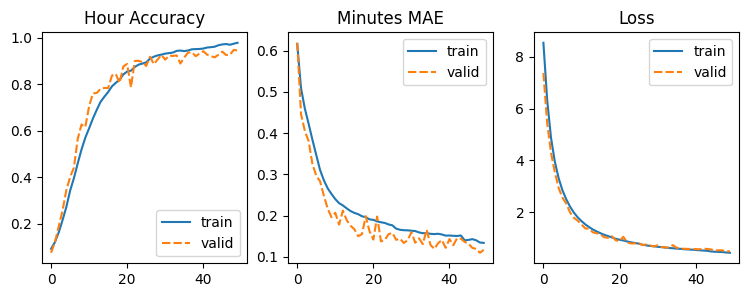

In [ ]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2.history['loss']
loss_df['valid'] = his_model_time_MH2.history['val_loss']
fig, axs = plt.subplots(ncols=3,figsize=(9,3))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
model_time_MH2.evaluate(test_tx,  {'hr_y': test_ty[:, 0], 'min_y':test_ty_period[:,2:] }, verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_hr_MH2,pred_min_MH2 = model_time_MH2.predict(test_tx)
pred_hr_MH2[:10],pred_min_MH2[:10]
hr_MH2 = np.argmax(tf.nn.softmax(pred_hr_MH2),axis=1)
min_MH2 = period_to_hrmin(pred_min_MH2,60)
hr_MH2[:10],min_MH2[:10]
pred_MH2 = np.array([hr_MH2,min_MH2]).T
print(test_ty[:3],pred_MH2[:3])
np.mean(common_sense_err2(test_ty,pred_MH2),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 42.]
 [ 4. 59.]
 [ 6.  8.]]


array([0.02055556, 3.84722222])

Single Angle Periodic transformation

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1.summary()
print(model_time_P1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1 = model_time_P1.fit(train_tx, single_angle_trans(train_ty),
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 3.7434 - mae: 0.6699 - val_loss: 2.9188 - val_mae: 0.6253 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.5433 - mae: 0.5037 - val_loss: 1.9023 - val_mae: 0.4397 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.7714 - mae: 0.4498 - val_loss: 1.3256 - val_mae: 0.3971 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2539 - mae: 0.4125 - val_loss: 0.9539 - val_mae: 0.3616 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9135 - mae: 0.3771 - val_loss: 0.7069 - val_mae: 0.3335 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.6846 - mae: 0.3422 - val_loss: 0.5270 - val_mae: 0.2853 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5282 - mae: 0.3105 -

57/57 - 0s - 6ms/step - loss: 0.0292 - mae: 0.0875


[0.029200129210948944, 0.08747129887342453]

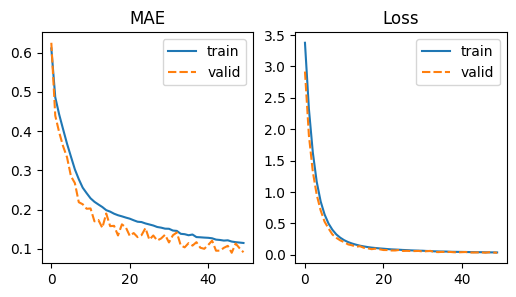

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1.history['mae']
mae_df['valid'] = his_model_time_P1.history['val_mae']
loss_df['train'] = his_model_time_P1.history['loss']
loss_df['valid'] = his_model_time_P1.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1.evaluate(test_tx,  single_angle_trans(test_ty), verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_y_P1 = model_time_P1.predict(test_tx)
pred_P1 = s_ang_to_clk(pred_y_P1)
print(test_ty[:3],pred_P1[:3])
np.mean(common_sense_err2(test_ty,pred_P1),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 40.]
 [ 5.  5.]
 [ 6.  8.]]


array([2.77777778e-03, 1.12527778e+01])

Periodic transformation

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(4)(x)

model_time_P2 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P2.summary()
print(model_time_P2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P2.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P2 = model_time_P2.fit(train_tx, train_ty_period,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,620 (1.78 MB)

 Trainable params: 467,172 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 3.6396 - mae: 0.6700 - val_loss: 2.5783 - val_mae: 0.6329 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.2238 - mae: 0.5489 - val_loss: 1.5370 - val_mae: 0.4869 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.4195 - mae: 0.4936 - val_loss: 1.0224 - val_mae: 0.4476 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9733 - mae: 0.4696 - val_loss: 0.7428 - val_mae: 0.4491 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7126 - mae: 0.4523 - val_loss: 0.5641 - val_mae: 0.4291 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5537 - mae: 0.4350 - val_loss: 0.4485 - val_mae: 0.4023 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.4504 - mae: 0.4132 -

57/57 - 0s - 6ms/step - loss: 0.0421 - mae: 0.1111


[0.04207534343004227, 0.1111031174659729]

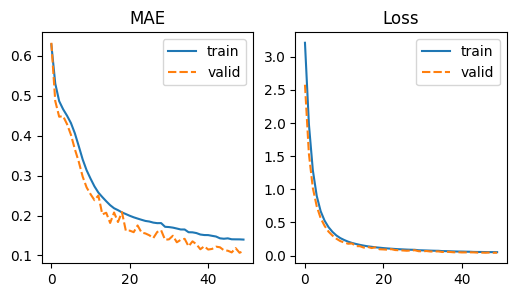

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P2.history['mae']
mae_df['valid'] = his_model_time_P2.history['val_mae']
loss_df['train'] = his_model_time_P2.history['loss']
loss_df['valid'] = his_model_time_P2.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P2.evaluate(test_tx,  test_ty_period, verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_y_P2 = model_time_P2.predict(test_tx)
pred_P2 = period_to_clk(pred_y_P2)
print(test_ty[:3],pred_P2[:3])
np.mean(common_sense_err2(test_ty,pred_P2),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 44.]
 [ 5. 59.]
 [ 6.  9.]]


array([0.04666667, 5.05444444])

Dual Regression, scaled

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_DR1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_DR1.summary()
print(model_time_DR1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_DR1.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])
train_ty2 = np.array([train_ty[:,0]/11,train_ty[:,1]/59]).T
his_model_time_DR1 = model_time_DR1.fit(train_tx, train_ty2,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 3.3172 - mae: 0.3641 - val_loss: 2.4133 - val_mae: 0.3618 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.0579 - mae: 0.2541 - val_loss: 1.3832 - val_mae: 0.2196 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2360 - mae: 0.2395 - val_loss: 0.8210 - val_mae: 0.2152 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7366 - mae: 0.2290 - val_loss: 0.5026 - val_mae: 0.2174 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.4536 - mae: 0.2234 - val_loss: 0.3157 - val_mae: 0.2091 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2940 - mae: 0.2214 - val_loss: 0.2119 - val_mae: 0.2049 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2015 - mae: 0.2149 -

57/57 - 0s - 4ms/step - loss: 0.0294 - mae: 0.0878


[0.029410745948553085, 0.08778808265924454]

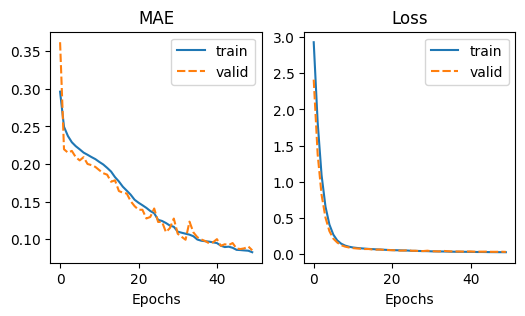

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_DR1.history['mae']
mae_df['valid'] = his_model_time_DR1.history['val_mae']
loss_df['train'] = his_model_time_DR1.history['loss']
loss_df['valid'] = his_model_time_DR1.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set(title = "MAE",xlabel='Epochs')
sns.lineplot(loss_df,ax=axs[1]).set(title = "Loss",xlabel='Epochs')
test_ty2 = np.array([test_ty[:,0]/11,test_ty[:,1]/59]).T
model_time_DR1.evaluate(test_tx,  test_ty2, verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_y_DR1 = model_time_DR1.predict(test_tx)
pred_DR1 = np.round(np.array([pred_y_DR1[:,0]*11,pred_y_DR1[:,1]*59]).T)
# pred_DR1 = np.round(pred_y_DR1)
print(test_ty[:3],pred_DR1[:3])
np.mean(common_sense_err2(test_ty,pred_DR1),axis = 0)
#array([ 1.41444444, 27.49444444])

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 4. 38.]
 [ 4. 32.]
 [ 6. 18.]]


array([ 0.48611111, 23.65611111])

Non scaled Dual regression

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_DR2 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_DR2.summary()
print(model_time_DR2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_DR2.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])
his_model_time_DR2 = model_time_DR2.fit(train_tx, train_ty,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 205.3792 - mae: 10.0758 - val_loss: 422.5236 - val_mae: 14.0642 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 154.5722 - mae: 8.7531 - val_loss: 133.0766 - val_mae: 7.6374 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 133.2008 - mae: 7.8635 - val_loss: 188.9287 - val_mae: 9.0622 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 123.9921 - mae: 7.4672 - val_loss: 128.2598 - val_mae: 7.3503 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 115.5191 - mae: 7.1588 - val_loss: 171.9513 - val_mae: 8.5970 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 106.5523 - mae: 6.8662 - val_loss: 100.8880 - val_mae: 6.3807 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - lo

57/57 - 0s - 6ms/step - loss: 58.5167 - mae: 4.4908


[58.51671600341797, 4.490756988525391]

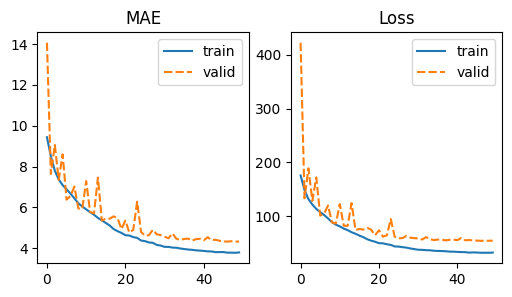

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_DR2.history['mae']
mae_df['valid'] = his_model_time_DR2.history['val_mae']
loss_df['train'] = his_model_time_DR2.history['loss']
loss_df['valid'] = his_model_time_DR2.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_DR2.evaluate(test_tx,  test_ty, verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_y_DR2 = model_time_DR2.predict(test_tx)
pred_DR2 = np.round(np.array([pred_y_DR2[:,0],pred_y_DR2[:,1]]).T)
# pred_DR1 = np.round(pred_y_DR1)
print(test_ty[:3],pred_DR2[:3])
np.mean(common_sense_err2(test_ty,pred_DR2),axis = 0)
#array([ 1.41444444, 27.49444444])

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 7. 30.]
 [ 4. 40.]
 [ 5. 12.]]


array([ 1.40222222, 31.49833333])

### 150 x 150

#### Import Data

In [5]:
time_x_L = np.load('images.npy')
time_y_L = np.load('labels.npy')
train_tx_L, test_tx_L, train_ty_L, test_ty_L = train_test_split(time_x_L, time_y_L, test_size=0.1, random_state=42)
train_ty_period_L = periodic_trans(train_ty_L)
test_ty_period_L = periodic_trans(test_ty_L)

#### Multi head scaled 

In [6]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(1,name='min_y')(min_y)

model_time_MH1_L = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH1_L.summary()
print(model_time_MH1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH1_L.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH1_L = model_time_MH1_L.fit(train_tx_L, {'hr_y': train_ty_L[:,0], 'min_y': train_ty_L[:,1]/59},
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping, reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 148, 148,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 34, 34,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 17, 17,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18496)     │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  2,367,616 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  2,367,616 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]   

 Total params: 4,810,157 (18.35 MB)

 Trainable params: 4,809,709 (18.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50


2024-11-08 13:27:56.737840: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 28 bytes spill stores, 28 bytes spill loads

2024-11-08 13:27:56.766760: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 56 bytes spill stores, 56 bytes spill loads

2024-11-08 13:27:56.796341: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 40 bytes spill stores, 40 bytes spill loads

2024-11-08 13:27:56.814231: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 16 bytes spill stores, 16 bytes spill loads

2024-11-08 13:27:56.846026: I external/local_xla/xla/stream_executor/cud

453/456 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - hr_y_accuracy: 0.0871 - hr_y_loss: 2.5831 - loss: 9.2021 - min_y_loss: 0.4901 - min_y_mae: 0.4565

2024-11-08 13:28:14.460044: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 56 bytes spill stores, 56 bytes spill loads

2024-11-08 13:28:14.516348: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 16 bytes spill stores, 16 bytes spill loads

2024-11-08 13:28:14.539971: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 28 bytes spill stores, 28 bytes spill loads

2024-11-08 13:28:14.559744: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 40 bytes spill stores, 40 bytes spill loads

2024-11-08 13:28:14.581319: I external/local_xla/xla/stream_executor/cud

456/456 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - hr_y_accuracy: 0.0871 - hr_y_loss: 2.5829 - loss: 9.1988 - min_y_loss: 0.4891 - min_y_mae: 0.4561 - val_hr_y_accuracy: 0.1130 - val_hr_y_loss: 2.4715 - val_loss: 6.9867 - val_min_y_loss: 0.1530 - val_min_y_mae: 0.3189 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - hr_y_accuracy: 0.1211 - hr_y_loss: 2.4297 - loss: 6.4635 - min_y_loss: 0.1158 - min_y_mae: 0.2799 - val_hr_y_accuracy: 0.1648 - val_hr_y_loss: 2.3376 - val_loss: 5.2488 - val_min_y_loss: 0.0825 - val_min_y_mae: 0.2371 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - hr_y_accuracy: 0.1662 - hr_y_loss: 2.3250 - loss: 4.9960 - min_y_loss: 0.0990 - min_y_mae: 0.2545 - val_hr_y_accuracy: 0.1790 - val_hr_y_loss: 2.2303 - val_loss: 4.2288 - val_min_y_loss: 0.0760 - val_min_y_mae: 0.2202 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - hr_y_accuracy: 0.1811 - hr_y_loss: 2.2052 - loss:

2024-11-08 13:41:09.202424: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 248 bytes spill stores, 272 bytes spill loads



57/57 - 1s - 20ms/step - hr_y_accuracy: 0.8483 - hr_y_loss: 0.4125 - loss: 0.7227 - min_y_loss: 0.0302 - min_y_mae: 0.1152
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


array([ 0.06388889, 10.36      ])

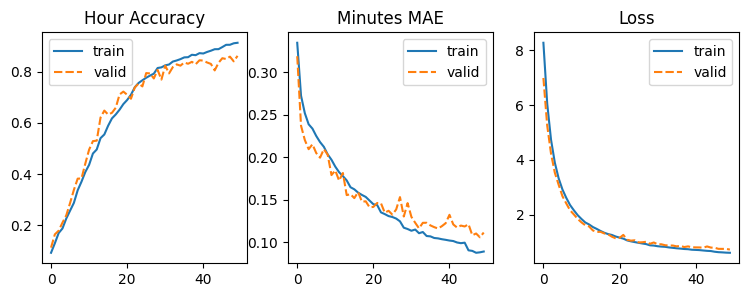

In [7]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH1_L.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH1_L.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH1_L.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH1_L.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH1_L.history['loss']
loss_df['valid'] = his_model_time_MH1_L.history['val_loss']
fig, axs = plt.subplots(ncols=3,figsize=(9,3))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
model_time_MH1_L.evaluate(test_tx_L,  {'hr_y': test_ty_L[:, 0], 'min_y': test_ty_L[:, 1] / 59}, verbose=2)
pred_hr_MH1_L,pred_min_MH1_L = model_time_MH1_L.predict(test_tx_L)
hr_MH1_L = np.argmax(tf.nn.softmax(pred_hr_MH1_L),axis=1)
min_MH1_L = np.round(pred_min_MH1_L*60).flatten()
hr_MH1_L[:10],min_MH1_L[:10]
pred_MH1_L = np.array([hr_MH1_L,min_MH1_L]).T
np.mean(common_sense_err2(test_ty_L,pred_MH1_L),axis = 0)

#### Multi head periodic

In [8]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2_L = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2_L.summary()
print(model_time_MH2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2_L.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2_L = model_time_MH2_L.fit(train_tx_L, {'hr_y': train_ty_L[:,0], 'min_y': train_ty_period_L[:,2:]},
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 148, 148,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 34, 34,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 17, 17,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18496)     │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  2,367,616 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  2,367,616 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]   

 Total params: 4,810,222 (18.35 MB)

 Trainable params: 4,809,774 (18.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - hr_y_accuracy: 0.0855 - hr_y_loss: 2.5715 - loss: 9.3075 - min_y_loss: 0.6651 - min_y_mae: 0.6858 - val_hr_y_accuracy: 0.0802 - val_hr_y_loss: 2.4832 - val_loss: 6.9116 - val_min_y_loss: 0.4449 - val_min_y_mae: 0.5956 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - hr_y_accuracy: 0.0865 - hr_y_loss: 2.4835 - loss: 6.3199 - min_y_loss: 0.3891 - min_y_mae: 0.5287 - val_hr_y_accuracy: 0.0975 - val_hr_y_loss: 2.4585 - val_loss: 4.9714 - val_min_y_loss: 0.3059 - val_min_y_mae: 0.4739 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - hr_y_accuracy: 0.1040 - hr_y_loss: 2.4579 - loss: 4.7057 - min_y_loss: 0.3304 - min_y_mae: 0.4821 - val_hr_y_accuracy: 0.1105 - val_hr_y_loss: 2.4272 - val_loss: 3.9710 - val_min_y_loss: 0.2655 - val_min_y_mae: 0.4280 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step

57/57 - 1s - 13ms/step - hr_y_accuracy: 0.8183 - hr_y_loss: 0.5051 - loss: 0.7734 - min_y_loss: 0.0400 - min_y_mae: 0.1450
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 9. 42.]
 [ 5. 59.]
 [ 6.  8.]]


array([0.10388889, 8.93277778])

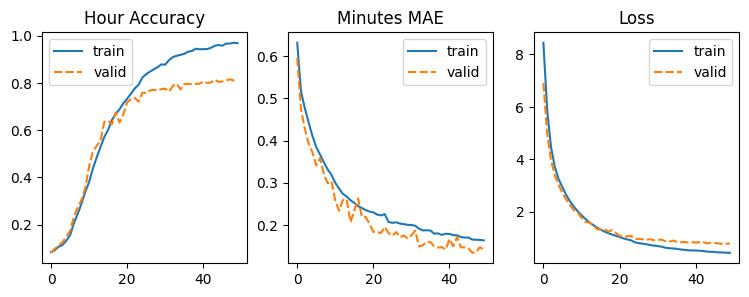

In [9]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2_L.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2_L.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2_L.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2_L.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2_L.history['loss']
loss_df['valid'] = his_model_time_MH2_L.history['val_loss']
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(9,3))
# plt.figure(figsize=(6,15))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
# axs[1, 1].axis('off')
model_time_MH2_L.evaluate(test_tx_L,  {'hr_y': test_ty_L[:, 0], 'min_y':test_ty_period_L[:,2:] }, verbose=2)
# print(test_ty[0:10])
pred_hr_MH2_L,pred_min_MH2_L = model_time_MH2_L.predict(test_tx_L)
pred_hr_MH2_L[:10],pred_min_MH2_L[:10]
hr_MH2_L = np.argmax(tf.nn.softmax(pred_hr_MH2_L),axis=1)
min_MH2_L = period_to_hrmin(pred_min_MH2_L,60)
hr_MH2_L[:10],min_MH2_L[:10]
pred_MH2_L = np.array([hr_MH2_L,min_MH2_L]).T
print(test_ty_L[:3],pred_MH2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_MH2_L),axis = 0)

#### Single Angle Periodic

In [10]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1_L.summary()
print(model_time_P1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1_L = model_time_P1_L.fit(train_tx_L, single_angle_trans(train_ty_L),
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433,570 (9.28 MB)

 Trainable params: 2,433,122 (9.28 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 3.8530 - mae: 0.6964 - val_loss: 2.7359 - val_mae: 0.6130 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 2.4553 - mae: 0.5667 - val_loss: 1.8201 - val_mae: 0.5483 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 1.6548 - mae: 0.5202 - val_loss: 1.2431 - val_mae: 0.4954 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 1.1496 - mae: 0.4877 - val_loss: 0.8633 - val_mae: 0.4377 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.7999 - mae: 0.4266 - val_loss: 0.5963 - val_mae: 0.3676 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.5657 - mae: 0.3675 - val_loss: 0.4395 - val_mae: 0.3311 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.4210 - 

57/57 - 1s - 9ms/step - loss: 0.0486 - mae: 0.1256
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1.  2.]
 [ 5.  3.]
 [ 5. 41.]]


array([ 0.02277778, 15.67888889])

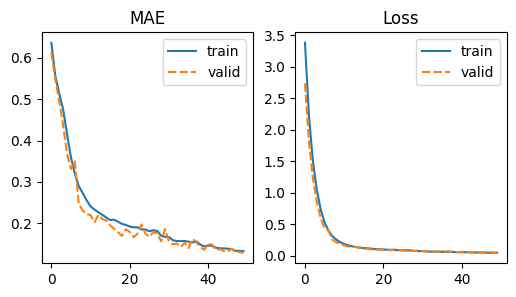

In [11]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1_L.history['mae']
mae_df['valid'] = his_model_time_P1_L.history['val_mae']
loss_df['train'] = his_model_time_P1_L.history['loss']
loss_df['valid'] = his_model_time_P1_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1_L.evaluate(test_tx_L,  single_angle_trans(test_ty_L), verbose=2)
# print(test_ty[0:10])
pred_y_P1_L = model_time_P1_L.predict(test_tx_L)
pred_P1_L = s_ang_to_clk(pred_y_P1_L)
print(test_ty_L[:3],pred_P1_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_P1_L),axis = 0)

#### Double angle periodic

In [12]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(4)(x)

model_time_P2_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P2_L.summary()
print(model_time_P2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P2_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P2_L = model_time_P2_L.fit(train_tx_L, train_ty_period_L,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433,700 (9.28 MB)

 Trainable params: 2,433,252 (9.28 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 3.6711 - mae: 0.6775 - val_loss: 2.4314 - val_mae: 0.6228 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 2.1132 - mae: 0.5796 - val_loss: 1.3795 - val_mae: 0.5096 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 1.2626 - mae: 0.5185 - val_loss: 0.8748 - val_mae: 0.4729 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.8223 - mae: 0.4864 - val_loss: 0.6186 - val_mae: 0.4581 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.5979 - mae: 0.4709 - val_loss: 0.4807 - val_mae: 0.4498 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.4722 - mae: 0.4584 - val_loss: 0.3985 - val_mae: 0.4404 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.4013 - 

57/57 - 1s - 10ms/step - loss: 0.0956 - mae: 0.1960
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 0. 43.]
 [ 5. 58.]
 [ 6. 12.]]


array([ 0.16111111, 14.31055556])

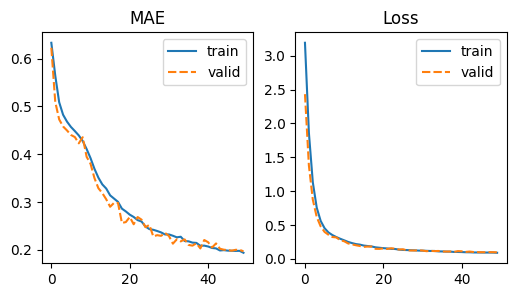

In [13]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P2_L.history['mae']
mae_df['valid'] = his_model_time_P2_L.history['val_mae']
loss_df['train'] = his_model_time_P2_L.history['loss']
loss_df['valid'] = his_model_time_P2_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P2_L.evaluate(test_tx_L,  test_ty_period_L, verbose=2)
# print(test_ty[0:10])
pred_y_P2_L = model_time_P2_L.predict(test_tx_L)
pred_P2_L = period_to_clk(pred_y_P2_L)
print(test_ty_L[:3],pred_P2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_P2_L),axis = 0)

In [14]:
# print(np.mean(common_sense_err2(test_ty_L[10:20],pred_P2_L[10:20]),axis = 0))
# test_ty_L[10:20],pred_P2_L[10:20]

#### Additional Layers

##### MH2 with additional conv layer

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 148, 148,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 34, 34,    │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]   

 Total params: 887,438 (3.39 MB)

 Trainable params: 886,926 (3.38 MB)

 Non-trainable params: 512 (2.00 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - hr_y_accuracy: 0.0854 - hr_y_loss: 2.5643 - loss: 9.3169 - min_y_loss: 0.6273 - min_y_mae: 0.6734 - val_hr_y_accuracy: 0.0827 - val_hr_y_loss: 2.4833 - val_loss: 7.5490 - val_min_y_loss: 0.5032 - val_min_y_mae: 0.6254 - learning_rate: 1.0000e-04
Epoch 2/50
130/456 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - hr_y_accuracy: 0.1066 - hr_y_loss: 2.4576 - loss: 7.2812 - min_y_loss: 0.4023 - min_y_mae: 0.5447

456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - hr_y_accuracy: 0.1132 - hr_y_loss: 2.4427 - loss: 6.9454 - min_y_loss: 0.3899 - min_y_mae: 0.5330 - val_hr_y_accuracy: 0.1537 - val_hr_y_loss: 2.3415 - val_loss: 5.6058 - val_min_y_loss: 0.2991 - val_min_y_mae: 0.4659 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - hr_y_accuracy: 0.1627 - hr_y_loss: 2.3138 - loss: 5.3193 - min_y_loss: 0.3238 - min_y_mae: 0.4767 - val_hr_y_accuracy: 0.2037 - val_hr_y_loss: 2.1699 - val_loss: 4.4283 - val_min_y_loss: 0.2746 - val_min_y_mae: 0.4405 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - hr_y_accuracy: 0.2038 - hr_y_loss: 2.1489 - loss: 4.2487 - min_y_loss: 0.2853 - min_y_mae: 0.4421 - val_hr_y_accuracy: 0.2648 - val_hr_y_loss: 1.9527 - val_loss: 3.5854 - val_min_y_loss: 0.2259 - val_min_y_mae: 0.3937 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - hr_y_accuracy: 0.2510 - hr_y_loss: 1.9688 - loss:

2024-11-08 14:32:41.011149: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 248 bytes spill stores, 272 bytes spill loads



57/57 - 1s - 19ms/step - hr_y_accuracy: 0.9606 - hr_y_loss: 0.1737 - loss: 0.4762 - min_y_loss: 0.0259 - min_y_mae: 0.1208
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 45.]
 [ 5.  0.]
 [ 6.  6.]]


array([0.01388889, 3.24833333])

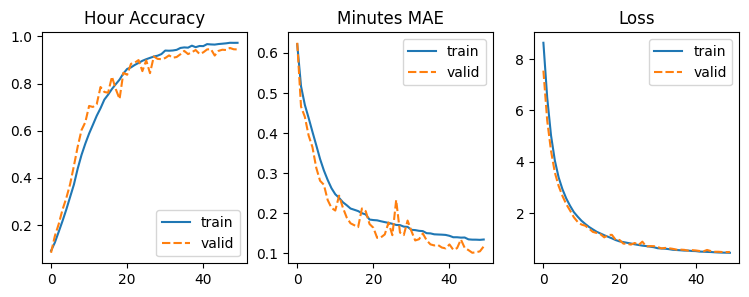

In [15]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2_L = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2_L.summary()
print(model_time_MH2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2_L.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2_L = model_time_MH2_L.fit(train_tx_L, {'hr_y': train_ty_L[:,0], 'min_y': train_ty_period_L[:,2:]},
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2_L.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2_L.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2_L.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2_L.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2_L.history['loss']
loss_df['valid'] = his_model_time_MH2_L.history['val_loss']
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(9,3))
# plt.figure(figsize=(6,15))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
# axs[1, 1].axis('off')
model_time_MH2_L.evaluate(test_tx_L,  {'hr_y': test_ty_L[:, 0], 'min_y':test_ty_period_L[:,2:] }, verbose=2)
pred_hr_MH2_L,pred_min_MH2_L = model_time_MH2_L.predict(test_tx_L)
pred_hr_MH2_L[:10],pred_min_MH2_L[:10]
hr_MH2_L = np.argmax(tf.nn.softmax(pred_hr_MH2_L),axis=1)
min_MH2_L = period_to_hrmin(pred_min_MH2_L,60)
hr_MH2_L[:10],min_MH2_L[:10]
pred_MH2_L = np.array([hr_MH2_L,min_MH2_L]).T
print(test_ty_L[:3],pred_MH2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_MH2_L),axis = 0)

##### Single Angle

In [17]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1_L.summary()
print(model_time_P1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1_L = model_time_P1_L.fit(train_tx_L, single_angle_trans(train_ty_L),
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1_L.history['mae']
mae_df['valid'] = his_model_time_P1_L.history['val_mae']
loss_df['train'] = his_model_time_P1_L.history['loss']
loss_df['valid'] = his_model_time_P1_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1_L.evaluate(test_tx_L,  single_angle_trans(test_ty_L), verbose=2)
# print(test_ty[0:10])
pred_y_P1_L = model_time_P1_L.predict(test_tx_L)
pred_P1_L = s_ang_to_clk(pred_y_P1_L)
print(test_ty_L[:3],pred_P1_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_P1_L),axis = 0)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,866 (1.82 MB)

 Trainable params: 476,354 (1.82 MB)

 Non-trainable params: 512 (2.00 KB)

<Functional name=functional, built=True>
Epoch 1/50
  3/456 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 6.1256 - mae: 1.2970

KeyboardInterrupt: 

##### Double Angle

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(4)(x)

model_time_P2_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P2_L.summary()
print(model_time_P2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P2_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P2_L = model_time_P2_L.fit(train_tx_L, train_ty_period_L,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P2_L.history['mae']
mae_df['valid'] = his_model_time_P2_L.history['val_mae']
loss_df['train'] = his_model_time_P2_L.history['loss']
loss_df['valid'] = his_model_time_P2_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P2_L.evaluate(test_tx_L,  test_ty_period_L, verbose=2)
# print(test_ty[0:10])
pred_y_P2_L = model_time_P2_L.predict(test_tx_L)
pred_P2_L = period_to_clk(pred_y_P2_L)
print(test_ty_L[:3],pred_P2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_P2_L),axis = 0)

##### Multi Head scaled

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(1,name='min_y')(min_y)

model_time_MH1_L = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH1_L.summary()
print(model_time_MH1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH1_L.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH1_L = model_time_MH1_L.fit(train_tx_L, {'hr_y': train_ty_L[:,0], 'min_y': train_ty_L[:,1]/59},
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping, reduce_lr])
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH1_L.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH1_L.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH1_L.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH1_L.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH1_L.history['loss']
loss_df['valid'] = his_model_time_MH1_L.history['val_loss']
fig, axs = plt.subplots(ncols=3,figsize=(9,3))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
model_time_MH1_L.evaluate(test_tx_L,  {'hr_y': test_ty_L[:, 0], 'min_y': test_ty_L[:, 1] / 59}, verbose=2)
pred_hr_MH1_L,pred_min_MH1_L = model_time_MH1_L.predict(test_tx_L)
hr_MH1_L = np.argmax(tf.nn.softmax(pred_hr_MH1_L),axis=1)
min_MH1_L = np.round(pred_min_MH1_L*60).flatten()
hr_MH1_L[:10],min_MH1_L[:10]
pred_MH1_L = np.array([hr_MH1_L,min_MH1_L]).T
np.mean(common_sense_err2(test_ty_L,pred_MH1_L),axis = 0)